In [1]:
%load_ext autoreload
%autoreload 2
from gui import SpikeImportGUI
from importers import SpikeImporter
from recordings import MNGRecording

# present the Spike GUI and let the user make his choices
spike_gui = SpikeImportGUI()

importer = SpikeImporter(filepath = spike_gui.filepath, time_channel = spike_gui.time_channel, signal_channel = spike_gui.signal_channel)
    
recording = MNGRecording.from_importer(importer = importer, stimulus_channels = spike_gui.stimulus_channels, \
                                      ap_channels = spike_gui.ap_channels, force_threshold = spike_gui.force_threshold, \
                                      max_ap_gap_time = spike_gui.max_ap_gap)

List of eletrical stimuli created.
Finished processing AP channel 1 out of 1
List of APs created.
Done with cropping the intervals


In [4]:
'''
Here, we extract some features from the APs:
- postpulse distance (aka latency)
- normalized signal energy
'''
%autoreload 2
from tqdm import tqdm
from feature_extraction import ResponseLatency, NormalizedSignalEnergy, SpikeCount, AdaptiveSpikeCount

print("Extracting features from every AP")
features = [ResponseLatency(regular_el_stimuli = recording.el_stimuli), \
            NormalizedSignalEnergy(), \
            SpikeCount(actpots = recording.actpots, timeframe = 100, num_intervals = 16), \
            AdaptiveSpikeCount(actpots = recording.actpots, timeframe = 100, num_splits = 8)]

for ap in tqdm(recording.actpots):
    # for each of the features, calculate and store in the ap's dict
    for feature in features:
        ap.features[feature.get_feature_name()] = feature.get_feature_value(ap)

    # also, save a reference to the previous electrical stimulus.
    # we might need that later.
    ap.prev_stimuli["regular"] = MNGRecording.get_prev_el_stimulus(ap, recording.el_stimuli)

 19%|██████████████▊                                                                 | 42/227 [00:00<00:00, 412.23it/s]

Extracting features from every AP


100%|███████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 489.31it/s]


In [49]:
%autoreload 2
from plotting import FallingLeafPlot
from ipywidgets import interact_manual, fixed, IntSlider, FloatSlider

tmin, tmax = importer.get_time_range()
max_interval_length = max([stim.interval_length for stim in recording.el_stimuli])

flplot = FallingLeafPlot()
interact_manual(flplot.plot, regular_stimuli = fixed(recording.el_stimuli), action_potentials = fixed(recording.actpots), \
                t_start = FloatSlider(min = tmin, max = tmax, value = 0), \
                num_intervals = IntSlider(min = 1, max = len(recording.el_stimuli), step = 1, value = 5), \
                post_stimulus_timeframe = FloatSlider(min = 0, max = max_interval_length, value = 0.1), \
                manual_name = "Update Plot")

interactive(children=(FloatSlider(value=0.0, description='t_start', max=440.0), IntSlider(value=5, description…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

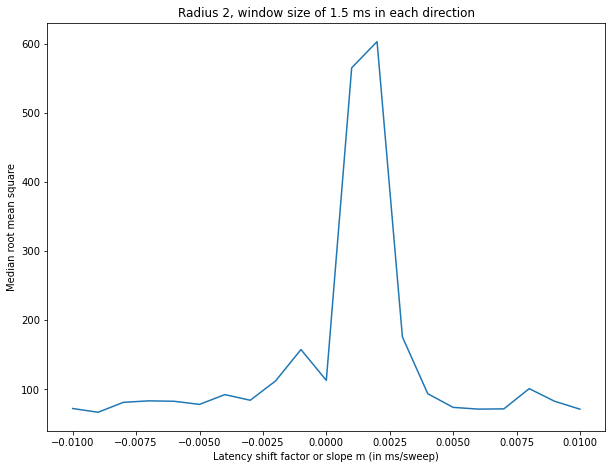

In [54]:
%autoreload 2
from metrics import median_RMS
import numpy as np
import matplotlib.pyplot as plt

sweeps = recording.split_into_sweeps()

shifts = np.linspace(start = -0.01, stop = 0.01, num = 21)
rms = [median_RMS(sweeps, center_sweep_idx = 7, latency_shift = sh, latency = 0.06, radius = 2, window_size = 0.0015) \
       for sh in shifts]

plt.figure(figsize = (10, 7.5))
plt.plot(shifts, rms)
plt.xlabel("Latency shift factor or slope m (in ms/sweep)")
plt.ylabel("Median root mean square")
plt.title("Radius 2, window size of 1.5 ms in each direction")
plt.show()

